In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [41]:

# Load the train data
train_data = pd.read_csv('/content/updated_data_train.csv')

# Encode categorical string columns using OneHotEncoder
string_columns = train_data.select_dtypes(include=['object']).columns
if len(string_columns) > 0:
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
    encoded_columns = encoder.fit_transform(train_data[string_columns])
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(string_columns))
    train_data = pd.concat([train_data.drop(columns=string_columns), encoded_df], axis=1)

# Extract necessary columns (Latitude, Longitude, Population, and any encoded features)
train_coords = train_data[['Latitude', 'Longitude', 'population'] + list(encoded_df.columns)]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()

# Create target values based on population threshold (e.g., 25th percentile)
population_threshold = train_coords['population'].quantile(0.25)
target_values = (train_coords['population'] > population_threshold).astype(int).values

train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

train_coords.values

<ipython-input-41-7ef4d1cd2f57>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


array([[0.72179133, 0.74843477, 0.0604019 , ..., 0.        , 0.        ,
        0.        ],
       [0.4579162 , 0.3247756 , 0.01849852, ..., 0.        , 0.        ,
        0.        ],
       [0.40801334, 0.69016527, 0.17248462, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.38197986, 0.80921567, 0.86889643, ..., 0.        , 0.        ,
        0.        ],
       [0.54404146, 0.54932331, 0.03592305, ..., 0.        , 0.        ,
        0.        ],
       [0.54372788, 0.55010351, 0.03592305, ..., 0.        , 0.        ,
        0.        ]])

In [42]:

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    print(idx)
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])
G

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [43]:

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] - train_coords['population'].iloc[neighbors[j]])
        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)
G

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    # Include all features: latitude, longitude, population, and encoded columns
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

# Adding additional encoded features to the node features
encoded_features = train_coords.drop(columns=['Latitude', 'Longitude', 'population']).values
node_features = np.concatenate([node_features, encoded_features], axis=1)

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])
node_features

array([[0.72179133, 0.74843477, 0.0604019 , ..., 0.        , 0.        ,
        0.        ],
       [0.4579162 , 0.3247756 , 0.01849852, ..., 0.        , 0.        ,
        0.        ],
       [0.40801334, 0.69016527, 0.17248462, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.38197986, 0.80921567, 0.86889643, ..., 0.        , 0.        ,
        0.        ],
       [0.54404146, 0.54932331, 0.03592305, ..., 0.        , 0.        ,
        0.        ],
       [0.54372788, 0.55010351, 0.03592305, ..., 0.        , 0.        ,
        0.        ]])

In [45]:

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Ensure edge indices are within the valid range of node indices
edge_index = edge_index.clamp(0, x.shape[0] - 1)  # Clamp indices to be within [0, num_nodes - 1]

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)


# Define the GCN model with approximately 10 layers for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(x.size(1), 16)  # Adjust input dimension dynamically
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Single output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Squeeze to make it compatible with BCE loss

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare binary target labels (1 for metro station, 0 for non-station)
# target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)
target_values = torch.tensor(target_values, dtype=torch.float)
# Train the model with accuracy tracking
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target_values)  # BCE loss
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    with torch.no_grad():
        predicted_labels = (out > 0.5).float()  # Convert probabilities to binary (0 or 1)
        correct = (predicted_labels == target_values).sum().item()
        accuracy = correct / target_values.size(0)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

# Post-process: Obtain predictions, apply threshold, and convert back to original latitude/longitude scale
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold at 0.5 to get binary labels

# Add the binary column for metro station prediction
train_data['Predicted_Metro_Station'] = predicted_labels

# Extract only the latitude and longitude for inverse scaling
predicted_coords = np.zeros((predicted_labels.shape[0], 3))
predicted_coords[:, :2] = train_coords[['Latitude', 'Longitude']].values
predicted_coords[:, 2] = predicted_labels  # Place binary predictions for scaling

# Inverse transform only the coordinates (Latitude and Longitude)
predicted_coords = scaler.inverse_transform(predicted_coords)
predicted_positions = predicted_coords[predicted_coords[:, 2] == 1, :2]  # Select predicted metro stations


Epoch 0, Loss: 0.6928213238716125, Accuracy: 49.29%
Epoch 10, Loss: 0.43707001209259033, Accuracy: 74.98%
Epoch 20, Loss: 0.40459173917770386, Accuracy: 74.98%
Epoch 30, Loss: 0.40336623787879944, Accuracy: 74.98%
Epoch 40, Loss: 0.39817968010902405, Accuracy: 74.98%
Epoch 50, Loss: 0.36400535702705383, Accuracy: 89.92%
Epoch 60, Loss: 0.2960900366306305, Accuracy: 90.06%
Epoch 70, Loss: 0.28584426641464233, Accuracy: 90.04%
Epoch 80, Loss: 0.2705334722995758, Accuracy: 90.04%
Epoch 90, Loss: 0.2491408884525299, Accuracy: 90.28%
Epoch 100, Loss: 0.2420376092195511, Accuracy: 90.40%
Epoch 110, Loss: 0.23887188732624054, Accuracy: 90.42%
Epoch 120, Loss: 0.23508641123771667, Accuracy: 90.47%
Epoch 130, Loss: 0.2325037717819214, Accuracy: 90.47%
Epoch 140, Loss: 0.2306564599275589, Accuracy: 90.54%
Epoch 150, Loss: 0.22914336621761322, Accuracy: 90.50%
Epoch 160, Loss: 0.22809691727161407, Accuracy: 90.54%
Epoch 170, Loss: 0.2272810935974121, Accuracy: 90.57%
Epoch 180, Loss: 0.2265835553

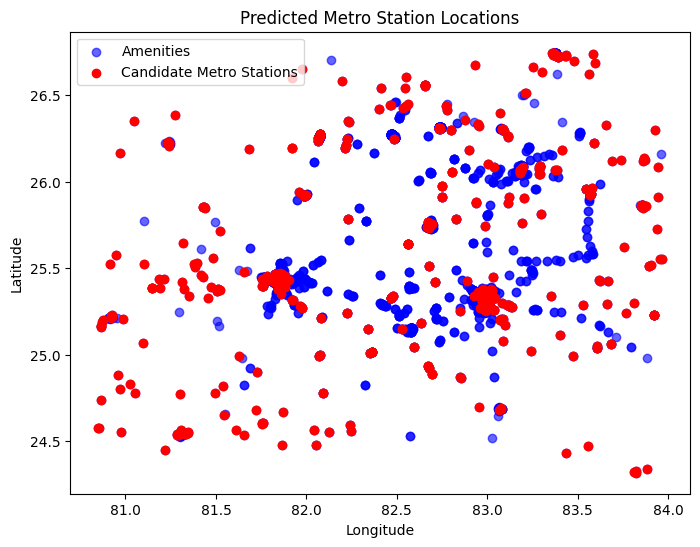

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Amenities', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Candidate Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [ ]:

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Amenities', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Candidate Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [47]:
# Load the train data
train_data = pd.read_csv('/content/updated_data_train.csv')

# Encode categorical string columns using OneHotEncoder
string_columns = train_data.select_dtypes(include=['object']).columns
if len(string_columns) > 0:
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
    encoded_columns = encoder.fit_transform(train_data[string_columns])
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(string_columns))
    train_data = pd.concat([train_data.drop(columns=string_columns), encoded_df], axis=1)

# Extract necessary columns (Latitude, Longitude, Population, and any encoded features)
train_coords = train_data[['Latitude', 'Longitude', 'population'] + list(encoded_df.columns)]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] + train_coords['population'].iloc[neighbors[j]])
        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    # Include all features: latitude, longitude, population, and encoded columns
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

# Adding additional encoded features to the node features
encoded_features = train_coords.drop(columns=['Latitude', 'Longitude', 'population']).values
node_features = np.concatenate([node_features, encoded_features], axis=1)

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(x.size(1), 16)  # Adjust input dimension dynamically
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Single output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Squeeze to make it compatible with BCE loss

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare binary target labels (1 for metro station, 0 for non-station)
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model with accuracy tracking
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    with torch.no_grad():
        predicted_labels = (out > 0.5).float()  # Convert probabilities to binary (0 or 1)
        correct = (predicted_labels == target).sum().item()
        accuracy = correct / target.size(0)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

# Post-process: Obtain predictions, apply threshold, and convert back to original latitude/longitude scale
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold at 0.5 to get binary labels

# Add the binary column for metro station prediction
train_data['Predicted_Metro_Station'] = predicted_labels

# Extract only the latitude and longitude for inverse scaling
predicted_coords = np.zeros((predicted_labels.shape[0], 3))
predicted_coords[:, :2] = train_coords[['Latitude', 'Longitude']].values
predicted_coords[:, 2] = predicted_labels  # Place binary predictions for scaling

# Inverse transform only the coordinates (Latitude and Longitude)
predicted_coords = scaler.inverse_transform(predicted_coords)
predicted_positions = predicted_coords[predicted_coords[:, 2] == 1, :2]  # Select predicted metro stations

<ipython-input-47-4c89d587ef68>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6931555867195129, Accuracy: 49.17%
Epoch 10, Loss: 0.5800929665565491, Accuracy: 73.74%
Epoch 20, Loss: 0.4513780474662781, Accuracy: 76.25%
Epoch 30, Loss: 0.40324467420578003, Accuracy: 76.39%
Epoch 40, Loss: 0.3442727029323578, Accuracy: 76.59%
Epoch 50, Loss: 0.3409377932548523, Accuracy: 79.00%
Epoch 60, Loss: 0.34289151430130005, Accuracy: 78.57%
Epoch 70, Loss: 0.33060261607170105, Accuracy: 77.04%
Epoch 80, Loss: 0.3227667808532715, Accuracy: 78.33%
Epoch 90, Loss: 0.32343706488609314, Accuracy: 77.21%
Epoch 100, Loss: 0.31960025429725647, Accuracy: 77.76%
Epoch 110, Loss: 0.3098798990249634, Accuracy: 78.96%
Epoch 120, Loss: 0.3004682958126068, Accuracy: 79.87%
Epoch 130, Loss: 0.31591036915779114, Accuracy: 77.28%
Epoch 140, Loss: 0.30403101444244385, Accuracy: 77.33%
Epoch 150, Loss: 0.2995237112045288, Accuracy: 83.58%
Epoch 160, Loss: 0.29032936692237854, Accuracy: 84.44%
Epoch 170, Loss: 0.30311861634254456, Accuracy: 78.86%
Epoch 180, Loss: 0.28423818945

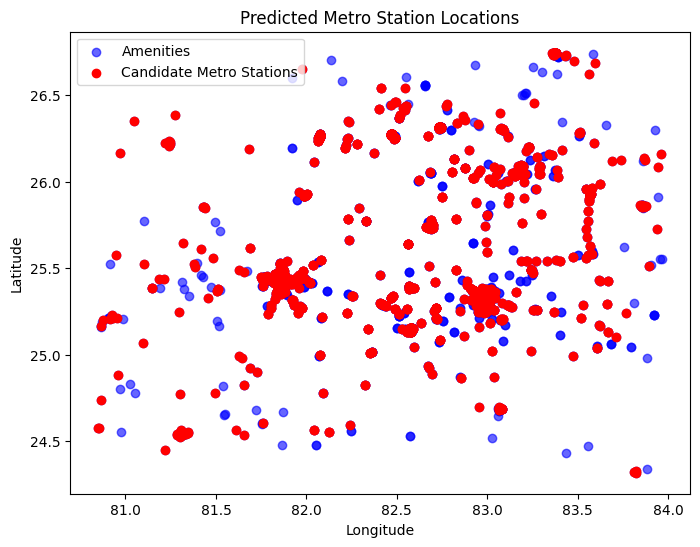

In [48]:

# Plot the original train data and predicted metro stations
plt.figure(figsize=(8, 6))
plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Amenities', alpha=0.6)
plt.scatter(predicted_positions[:, 1], predicted_positions[:, 0], color='red', label='Candidate Metro Stations')
plt.title('Predicted Metro Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()
